In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

In [32]:
df = pd.read_parquet("s3://projectdatagroup1/OmkarSample/SampleInput/TransformedOutput/part-00000-adc4b278-76eb-45ef-afe0-933481911f60-c000.snappy.parquet")

In [33]:
df.head()

,Airline,Origin,Dest,Cancelled,Diverted,Year,Quarter,Month,DayofMonth,DayOfWeek,...,WheelsOff,WheelsOn,TaxiIn,SchdArrTime,Day,Hour,Date,__index_level_0__,SchdDepHour,DelayCategory
0,Alaska Airlines Inc.,LAX,SEA,False,False,2018,1,1,1,1,...,110.0,317.0,6.0,233,2018-01-01,0.0,2018-01-01,0,23,Short Delay
1,Southwest Airlines Co.,DEN,SFO,False,False,2018,1,1,1,1,...,132.0,241.0,8.0,15,2018-01-01,1.0,2018-01-01,1,22,Long Delay
2,United Air Lines Inc.,DEN,SFO,False,False,2018,1,1,1,1,...,546.0,705.0,9.0,722,2018-01-01,5.0,2018-01-01,2,5,No Delay
3,Delta Air Lines Inc.,OAK,SLC,False,False,2018,1,1,1,1,...,617.0,834.0,4.0,850,2018-01-01,5.0,2018-01-01,3,6,No Delay
4,United Air Lines Inc.,DFW,LAX,False,False,2018,1,1,1,1,...,556.0,656.0,24.0,734,2018-01-01,5.0,2018-01-01,4,5,No Delay


In [34]:
bins = [0, 6, 12, 18, 24]
labels = ['Night', 'Morning', 'Afternoon', 'Evening']
df['SchdDepTimeOfDay'] = pd.cut(df['SchdDepHour'], bins=bins, labels=labels, right=False)
df["IsWeekend"] = df["DayOfWeek"].apply(lambda x: 1 if x in [6, 7] else 0)

In [35]:
# Define features and target
X = df.drop(columns=["DelayCategory","OriginStateName", "DestStateName", "__index_level_0__", "Cancelled","Diverted", "Day", "Hour", "Date" ], axis=1)  # Features
y = df["DelayCategory"]  # Target

In [36]:
X.columns

Index(['Airline', 'Origin', 'Dest', 'Year', 'Quarter', 'Month', 'DayofMonth',
       'DayOfWeek', 'TaxiOut', 'WheelsOff', 'WheelsOn', 'TaxiIn',
       'SchdArrTime', 'SchdDepHour', 'SchdDepTimeOfDay', 'IsWeekend'],
      dtype='object')

In [37]:
len(X.columns)

16

In [38]:
categorical_cols = ['Airline', 'Origin', 'Dest', 'SchdDepTimeOfDay']
numerical_cols = [
    "SchdDepHour", "Year", "Quarter", "Month", "DayofMonth", "DayOfWeek",
    "TaxiOut", "WheelsOff", "WheelsOn", "TaxiIn", "SchdArrTime", "IsWeekend"
]

In [ ]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),  # Scale numerical features
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),  # One-hot encode categorical features
    ]
)

## Preprocessor (PKL/JOBLIB File)

In [40]:
joblib.dump(preprocessor, "preprocessor.joblib")

['preprocessor.joblib']

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
y_train.head()

266382      No Delay
152972      No Delay
600582    Long Delay
265628      No Delay
399079      No Delay
Name: DelayCategory, dtype: object

In [48]:
# Apply preprocessing
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [63]:
X_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 9474608 stored elements and shape (592163, 818)>

In [56]:
X_test

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2368656 stored elements and shape (148041, 818)>

In [58]:
# Convert target to numerical labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [64]:
joblib.dump(label_encoder, "label_encoder.joblib")

['label_encoder.joblib']

In [70]:
# Save the mapping as a dictionary for reference
label_mapping = {class_label: index for index, class_label in enumerate(label_encoder.classes_)}
joblib.dump(label_mapping, "label_encoder.joblib")
label_mapping

{'Long Delay': 0,
 'Medium Delay': 1,
 'No Delay': 2,
 'Short Delay': 3,
 'Very Long Delay': 4}

In [65]:
for index, class_label in enumerate(label_encoder.classes_):
    print(f"Original Label: {class_label} -> Encoded Value: {index}")


Original Label: Long Delay -> Encoded Value: 0
Original Label: Medium Delay -> Encoded Value: 1
Original Label: No Delay -> Encoded Value: 2
Original Label: Short Delay -> Encoded Value: 3
Original Label: Very Long Delay -> Encoded Value: 4


In [59]:
y_train

array([2, 2, 0, ..., 0, 2, 2])

In [71]:
%pip install xgboost pandas scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [72]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

In [20]:
import boto3
import joblib
import pickle
from xgboost import XGBClassifier


In [24]:
import boto3

session = boto3.Session()
credentials = session.get_credentials()

if credentials:
    print("AWS credentials found.")
else:
    print("AWS credentials NOT found. Run `aws configure` to set up.")


AWS credentials found.


In [73]:
# Initialize the model
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train the model
xgb.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb.predict(X_test)

# Evaluate accuracy
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb:.4f}")
print(classification_report(y_test, y_pred_xgb))

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:23:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.9714
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1803
           1       0.91      0.87      0.89      5255
           2       0.98      0.99      0.99    123670
           3       0.92      0.85      0.88     17234
           4       0.65      0.16      0.26        79

    accuracy                           0.97    148041
   macro avg       0.87      0.75      0.78    148041
weighted avg       0.97      0.97      0.97    148041



Confusion Matrix:
[[  1587    203      5      1      7]
 [   109   4593     32    521      0]
 [     1      0 122997    672      0]
 [     0    237   2385  14612      0]
 [    65      1      0      0     13]]


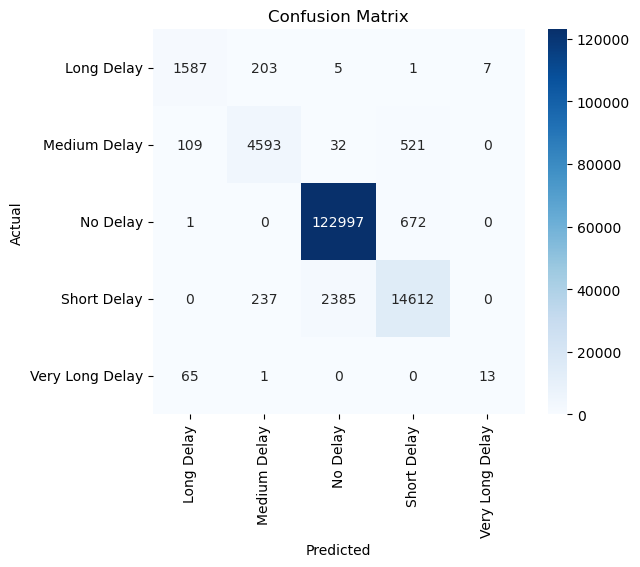

In [76]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)

# Retrieve class labels from the label encoder
class_labels = label_encoder.classes_  # Gets the original category names

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [75]:
import joblib

# Save the trained model as a joblib file
model_filename = "xgboost_model.joblib"
joblib.dump(xgb, model_filename)

print(f"Model saved as {model_filename}")


Model saved as xgboost_model.joblib
